In [24]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from ultralytics import YOLO

In [25]:
# Đọc ảnh
image_path = 'images\\bo du lieu bia so 7\\bia7 (14).bmp'
image = cv2.imread(image_path)

# Chuyển sang RGB để hiển thị bằng matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Chuyển ảnh sang grayscale để xử lý biên
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

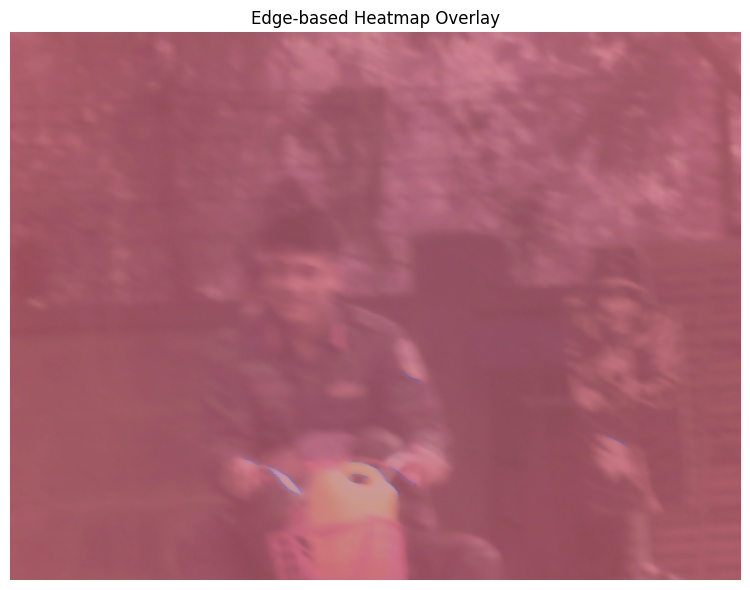

In [26]:
# Re-attempt edge-based heatmap using Canny edge detection
edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

# Apply a colormap for visualization
edges_colored = cv2.applyColorMap(edges, cv2.COLORMAP_JET)

# Overlay the edge map on the original image
overlayed_edges = cv2.addWeighted(image_rgb, 0.6, edges_colored, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_edges)
plt.axis('off')
plt.title("Edge-based Heatmap Overlay")
plt.tight_layout()
plt.show()


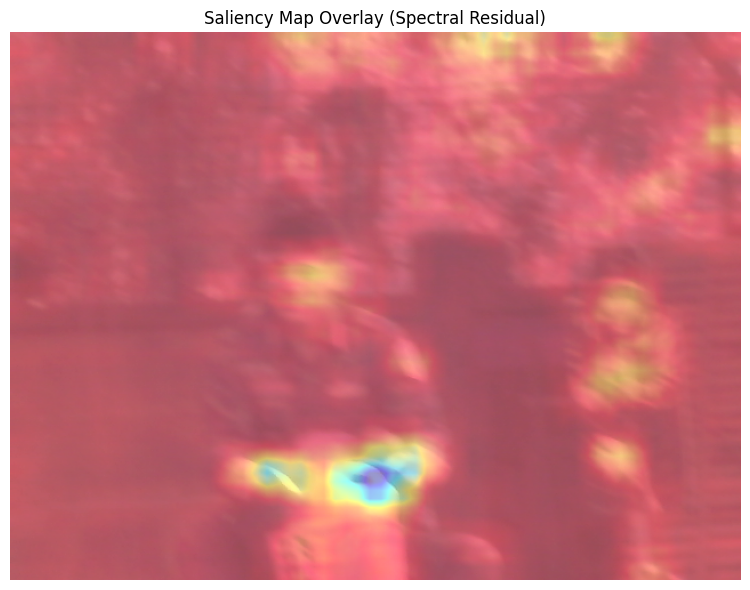

In [27]:
# Khởi tạo mô hình Saliency (Spectral Residual)
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()

# Tính toán bản đồ saliency
(success, saliency_map) = saliency.computeSaliency(image)

# Chuyển sang ảnh 8-bit để hiển thị
saliency_map_uint8 = (saliency_map * 255).astype("uint8")

# Áp dụng colormap để dễ quan sát
saliency_colored = cv2.applyColorMap(saliency_map_uint8, cv2.COLORMAP_JET)

# Chồng saliency map lên ảnh gốc
overlayed_saliency = cv2.addWeighted(image_rgb, 0.6, saliency_colored, 0.4, 0)

# Hiển thị kết quả
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_saliency)
plt.axis('off')
plt.title("Saliency Map Overlay (Spectral Residual)")
plt.tight_layout()
plt.show()

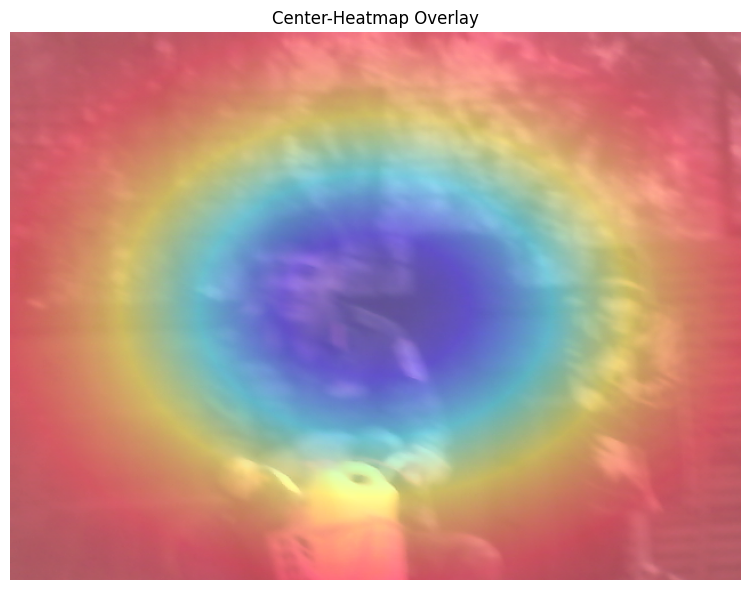

In [28]:
h, w = gray_image.shape

x = np.linspace(-1, 1, w)
y = np.linspace(-1, 1, h)
x_grid, y_grid = np.meshgrid(x, y)
d = np.sqrt(x_grid**2 + y_grid**2)
sigma, mu = 0.5, 0.0
heatmap = np.exp(-((d - mu)**2 / (2.0 * sigma**2)))

# Normalize heatmap to [0, 255] and convert to uint8
heatmap_normalized = np.uint8(255 * heatmap)

# Apply a colormap to the heatmap
heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
overlayed_image = cv2.addWeighted(image_rgb, 0.6, heatmap_colored, 0.4, 0)

# Show the result
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_image)
plt.axis('off')
plt.title("Center-Heatmap Overlay")
plt.tight_layout()
plt.show()

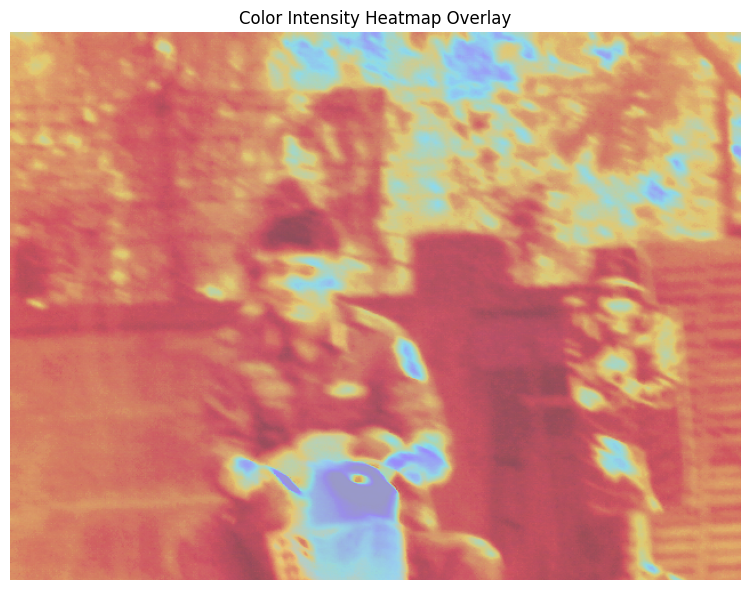

In [29]:
# Chuẩn hóa ảnh sang 0–255 nếu chưa chuẩn
intensity_map = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

# Áp dụng colormap để tạo heatmap từ độ sáng
intensity_colored = cv2.applyColorMap(intensity_map, cv2.COLORMAP_JET)

# Chồng heatmap lên ảnh gốc
overlayed_intensity = cv2.addWeighted(image_rgb, 0.6, intensity_colored, 0.4, 0)

# Hiển thị kết quả
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_intensity)
plt.axis('off')
plt.title("Color Intensity Heatmap Overlay")
plt.tight_layout()
plt.show()


0: 480x640 1 person, 986.0ms
Speed: 1.9ms preprocess, 986.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


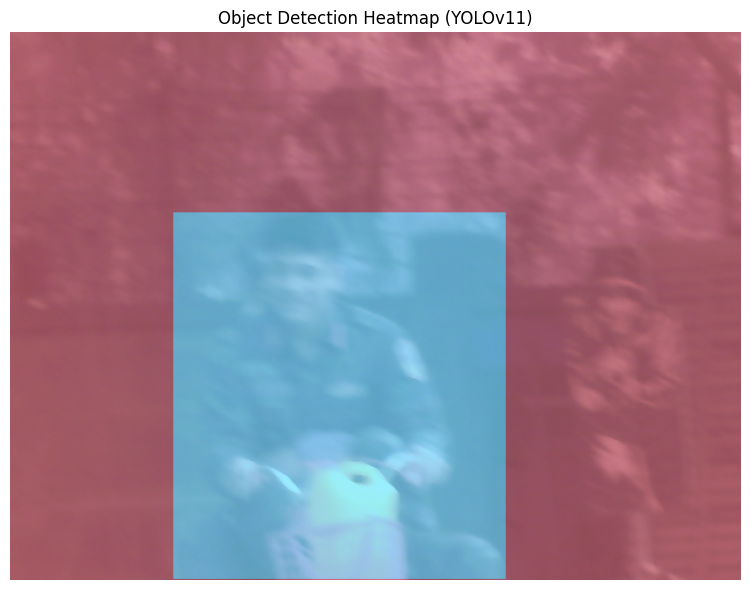

In [30]:
model_path = "yolo-models\\yolo11x.pt"
model = YOLO(model_path)

# Run inference
results = model(image_rgb)

# Parse results
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

# Tạo heatmap từ bounding boxes
for result in results[0].boxes:
    x1, y1, x2, y2 = map(int, result.xyxy[0])  # Tọa độ hộp giới hạn thẳng đứng
    label = model.names[int(result.cls)]  # Tên nhãn
    confidence = float(result.conf)  # Chuyển Tensor sang float
    heatmap[y1:y2, x1:x2] += confidence  # tăng giá trị theo độ tin cậy

# Chuẩn hóa heatmap về 0-255
heatmap = np.clip(heatmap, 0, 1)
heatmap_uint8 = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

# Overlay heatmap lên ảnh gốc
overlay = cv2.addWeighted(image_rgb, 0.6, heatmap_color, 0.4, 0)

# Hiển thị
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Object Detection Heatmap (YOLOv11)")
plt.tight_layout()
plt.show()